<a href="https://colab.research.google.com/github/ashleynguyen04/DS4002/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Creating dataset
#Download "Large Movie Review Dataset v1.0" from https://ai.stanford.edu/~amaas/data/sentiment/
#Download "title.basics.tsv.gz" from https://datasets.imdbws.com/
#Upload aclImd zip file and extracted title.basic.tsv to colab

import os
import re
import tarfile
import zipfile
import pandas as pd
from pathlib import Path
from google.colab import files

# CONFIGURE PATHS
ACL_ARCHIVE_TGZ = Path("/aclImdb_v1.tar.gz")   #copy and paste the path
ACL_ARCHIVE_ZIP = None
TITLE_BASICS_PATH = Path("/title.basics.tsv") # #copy and paste the path
ACL_ROOT_DIR = Path("/content/aclImdb") # will exist after aclIMDb is unzipped
OUTPUT_PARQUET = Path("/content/imdb_sentiment_with_genres.parquet")
OUTPUT_CSV = Path("/content/imdb_sentiment_with_genres.csv")
WRITE_CSV_TOO = False

TT_RE = re.compile(r"(tt\d+)")
STAR_RE = re.compile(r"_(\d+)\.txt$", re.IGNORECASE)

def extract_archive_if_needed(target_dir: Path):
    if target_dir.exists() and (target_dir / "train").exists() and (target_dir / "test").exists():
        print(f"Found existing {target_dir}, skipping extraction.")
        return
    if ACL_ARCHIVE_TGZ and Path(ACL_ARCHIVE_TGZ).exists():
        print(f"Extracting {ACL_ARCHIVE_TGZ} -> /content/ ...")
        with tarfile.open(ACL_ARCHIVE_TGZ, "r:gz") as tf:
            tf.extractall("/content/")
        print("Extraction (tar.gz) complete.")
    elif ACL_ARCHIVE_ZIP and Path(ACL_ARCHIVE_ZIP).exists():
        print(f"Extracting {ACL_ARCHIVE_ZIP} -> /content/ ...")
        with zipfile.ZipFile(ACL_ARCHIVE_ZIP, "r") as zf:
            zf.extractall("/content/")
        print("Extraction (zip) complete.")
    else:
        raise FileNotFoundError("Upload aclImdb_v1.tar.gz (or aclImdb.zip) to /content.")

def find_acl_root(base: Path) -> Path:
    def is_acl_root(p: Path) -> bool:
        return (p / "train" / "pos").exists() and (p / "train" / "neg").exists() \
           and (p / "test" / "pos").exists() and (p / "test" / "neg").exists()
    if is_acl_root(base):
        return base
    for root, dirs, files in os.walk(base):
        p = Path(root)
        if is_acl_root(p):
            return p
    raise RuntimeError(f"Could not find aclImdb root with train/test pos/neg under: {base}")

def read_split_sentiment(split_dir: Path, sentiment: str) -> pd.DataFrame:
    reviews_dir = split_dir / sentiment
    urls_file = split_dir / f"urls_{sentiment}.txt"

    review_files = sorted([p for p in reviews_dir.glob("*.txt") if p.is_file()])
    if not review_files:
        print(f"WARNING: No review files in {reviews_dir}")
        return pd.DataFrame(columns=["review_path", "review", "rating", "tt_id", "review_stars"])

    if not urls_file.exists():
        raise FileNotFoundError(f"Missing URLs file: {urls_file}")

    with urls_file.open("r", encoding="utf-8") as f:
        urls = [line.strip() for line in f if line.strip()]

    n = min(len(urls), len(review_files))
    if len(urls) != len(review_files):
        print(f"NOTE: {split_dir.name}-{sentiment} count mismatch. URLs={len(urls)} reviews={len(review_files)}. Using {n}.")
    urls = urls[:n]
    review_files = review_files[:n]

    tt_ids, rows = [], []
    for u in urls:
        m = TT_RE.search(u)
        tt_ids.append(m.group(1) if m else None)

    for fpath, tt in zip(review_files, tt_ids):
        with fpath.open("r", encoding="utf-8") as rf:
            text = rf.read().strip()
        mstar = STAR_RE.search(fpath.name)
        star = int(mstar.group(1)) if mstar else None
        rows.append({
            "review_path": str(fpath),
            "review": text,
            "rating": "pos" if sentiment == "pos" else "neg",
            "tt_id": tt,
            "review_stars": star
        })
    return pd.DataFrame(rows)

def load_acl_imdb_all(acl_root: Path) -> pd.DataFrame:
    dfs = []
    for split in ["train", "test"]:
        sd = acl_root / split
        if not sd.exists():
            print(f"WARNING: Missing split dir {sd}")
            continue
        for sentiment in ["pos", "neg"]:
            dfs.append(read_split_sentiment(sd, sentiment))
    if not dfs:
        return pd.DataFrame(columns=["review_path", "review", "rating", "tt_id", "review_stars"])
    return pd.concat(dfs, ignore_index=True)

def load_title_basics(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", dtype=str, na_values="\\N")
    df = df[["tconst", "primaryTitle", "genres"]]
    df["genres"] = df["genres"].fillna("")
    return df

#PIPELINE TO MERGE DATASET
try:
    extract_archive_if_needed(ACL_ROOT_DIR)
    acl_root = find_acl_root(ACL_ROOT_DIR)
    print(f"Using ACL root: {acl_root}")

    print("Loading ACL IMDB reviews…")
    reviews_df = load_acl_imdb_all(acl_root)
    if reviews_df.empty:
        raise RuntimeError("No reviews loaded.")

    print("Loading IMDb title.basics.tsv…")
    titles_df = load_title_basics(TITLE_BASICS_PATH)

    print("Merging on IMDb IDs…")
    reviews_df = reviews_df.dropna(subset=["tt_id"])
    need_ids = reviews_df["tt_id"].unique()
    titles_small = titles_df[titles_df["tconst"].isin(need_ids)].copy()

    merged = reviews_df.merge(titles_small, left_on="tt_id", right_on="tconst", how="left")

    merged["movie_name"] = merged["primaryTitle"].fillna("Unknown Title")
    merged["genres"] = merged["genres"].fillna("").astype(str)
    merged["genres_list"] = merged["genres"].apply(lambda s: [] if s.strip() == "" else s.split(","))
    long_df = merged.explode("genres_list", ignore_index=True)
    long_df = long_df.rename(columns={"genres_list": "genre"})
    long_df.loc[long_df["genre"] == "", "genre"] = None

    final = long_df.rename(columns={"tt_id": "imdb_identifier"})[
        ["imdb_identifier", "movie_name", "genres", "genre", "review", "rating", "review_stars"]
    ].copy()

    #TYPE CASTING: strings for text columns, Int for review_stars
    str_cols = ["imdb_identifier", "movie_name", "genres", "genre", "review", "rating"]
    final[str_cols] = final[str_cols].astype(pd.StringDtype())
    final["review_stars"] = final["review_stars"].astype("Int64")  # nullable integer

    print(final.dtypes)

    final.to_parquet(OUTPUT_PARQUET, index=False)
    print(f"Saved Parquet: {OUTPUT_PARQUET}")

    if WRITE_CSV_TOO:
        final.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
        print(f"Saved CSV: {OUTPUT_CSV}")

    # quick peek
    print("\nPreview:")
    print(final.head(3))

except Exception as e:
    print("\nERROR:", e)
    raise


Extracting /aclImdb_v1.tar.gz -> /content/ ...


/tmp/ipython-input-460011097.py:34: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall("/content/")


Extraction (tar.gz) complete.
Using ACL root: /content/aclImdb
Loading ACL IMDB reviews…
Loading IMDb title.basics.tsv…
Merging on IMDb IDs…
imdb_identifier    string[python]
movie_name         string[python]
genres             string[python]
genre              string[python]
review             string[python]
rating             string[python]
review_stars                Int64
dtype: object
Saved Parquet: /content/imdb_sentiment_with_genres.parquet

Preview:
  imdb_identifier     movie_name            genres      genre  \
0       tt0453418  Bromwell High  Animation,Comedy  Animation   
1       tt0453418  Bromwell High  Animation,Comedy     Comedy   
2       tt0453418  Bromwell High  Animation,Comedy  Animation   

                                              review rating  review_stars  
0  Bromwell High is a cartoon comedy. It ran at t...    pos             9  
1  Bromwell High is a cartoon comedy. It ran at t...    pos             9  
2  Homelessness (or Houselessness as George Carli

In [ ]:
# Load your Parquet dataset
import pandas as pd
df = pd.read_parquet("/content/imdb_sentiment_with_genres.parquet")

In [ ]:
#Preview the dataset
print(df.shape)
print(df.columns)
print(df.dtypes)

df.head(20)

(114139, 7)
Index(['imdb_identifier', 'movie_name', 'genres', 'genre', 'review', 'rating',
       'review_stars'],
      dtype='object')
imdb_identifier    string[python]
movie_name         string[python]
genres             string[python]
genre              string[python]
review             string[python]
rating             string[python]
review_stars                Int64
dtype: object


,imdb_identifier,movie_name,genres,genre,review,rating,review_stars
0,tt0453418,Bromwell High,"Animation,Comedy",Animation,Bromwell High is a cartoon comedy. It ran at t...,pos,9
1,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Bromwell High is a cartoon comedy. It ran at t...,pos,9
2,tt0453418,Bromwell High,"Animation,Comedy",Animation,Homelessness (or Houselessness as George Carli...,pos,8
3,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Homelessness (or Houselessness as George Carli...,pos,8
4,tt0453418,Bromwell High,"Animation,Comedy",Animation,Brilliant over-acting by Lesley Ann Warren. Be...,pos,10
5,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Brilliant over-acting by Lesley Ann Warren. Be...,pos,10
6,tt0064354,Futz,Comedy,Comedy,This is easily the most underrated film inn th...,pos,7
7,tt0064354,Futz,Comedy,Comedy,This is not the typical Mel Brooks film. It wa...,pos,8
8,tt0100680,Stanley & Iris,"Drama,Romance",Drama,"This isn't the comedic Robin Williams, nor is ...",pos,8
9,tt0100680,Stanley & Iris,"Drama,Romance",Romance,"This isn't the comedic Robin Williams, nor is ...",pos,8


In [ ]:
# Looking at what years the movies are from
# Reload the title.basics.tsv to get year info
titles = pd.read_csv("/title.basics.tsv", sep="\t", dtype=str, na_values="\\N")

# Merge startYear onto your dataset
df = df.merge(
    titles[["tconst", "startYear"]],
    left_on="imdb_identifier",
    right_on="tconst",
    how="left"
)

# Clean up
df = df.drop(columns=["tconst"])
df["startYear"] = df["startYear"].fillna("Unknown")

# Check distribution
print(df["startYear"].value_counts().head(10))


startYear
2006    7457
2005    7094
2003    5481
2004    5064
2007    4970
2000    4773
2002    4691
2001    4434
1999    4225
1998    3277
Name: count, dtype: int64


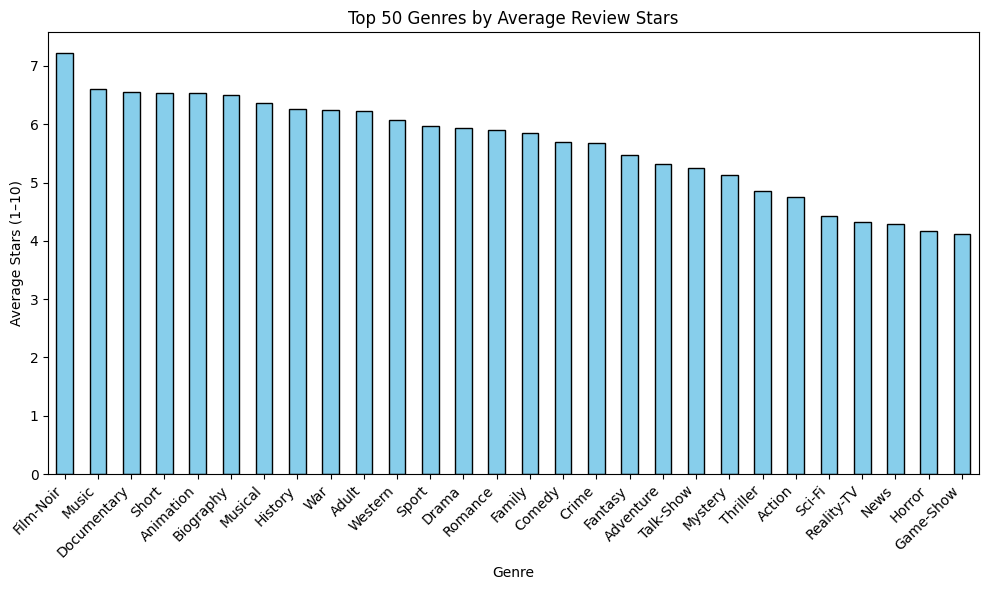

      movie_name  startYear rating
0  Bromwell High     2005.0    pos
1  Bromwell High     2005.0    pos
2  Bromwell High     2005.0    pos
3  Bromwell High     2005.0    pos
4  Bromwell High     2005.0    pos
   startYear rating  count
0     1894.0    neg      2
1     1894.0    pos     10
2     1895.0    pos     24
3     1897.0    pos      8
4     1902.0    neg      2


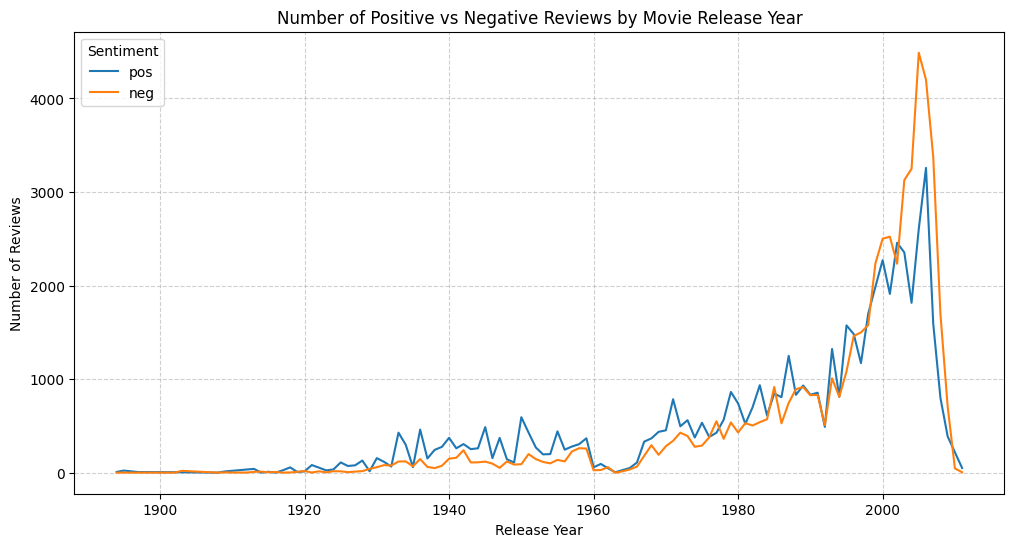

In [ ]:
#EDA
import matplotlib.pyplot as plt

######## REVIEW STARS BY GENRE #########
# Drop rows with missing review_stars
genre_ratings = df.dropna(subset=["review_stars"])

# Group by genre → average review_stars
genre_avg = (genre_ratings
             .groupby("genre")["review_stars"]
             .mean()
             .sort_values(ascending=False))

# Plot top 50 genres by average stars
plt.figure(figsize=(10,6))
genre_avg.head(50).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 50 Genres by Average Review Stars")
plt.ylabel("Average Stars (1–10)")
plt.xlabel("Genre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


######## # OF POS AND NEG REVIEW THROUGHOUT THE YEARS #########
# Reload IMDb basics WITH startYear this time
titles = pd.read_csv(
    "/title.basics.tsv",
    sep="\t",
    dtype=str,
    na_values="\\N"
)

# Merge startYear into df
df = df.merge(
    titles[["tconst", "startYear"]],
    left_on="imdb_identifier",
    right_on="tconst",
    how="left"
)

# Clean up
df = df.drop(columns=["tconst"])
df["startYear"] = pd.to_numeric(df["startYear"], errors="coerce")

print(df[["movie_name", "startYear", "rating"]].head())

yearly_counts = (
    df.dropna(subset=["startYear"])
      .groupby(["startYear", "rating"])
      .size()
      .reset_index(name="count")
)

print(yearly_counts.head())

plt.figure(figsize=(12,6))

for sentiment in ["pos", "neg"]:
    subset = yearly_counts[yearly_counts["rating"] == sentiment]
    plt.plot(subset["startYear"], subset["count"], label=sentiment)

plt.title("Number of Positive vs Negative Reviews by Movie Release Year")
plt.xlabel("Release Year")
plt.ylabel("Number of Reviews")
plt.legend(title="Rating")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()